# Linear regression example

This tutorial demonstrates the application of linear regression to test for QTL associations.

In [1]:
#set up plotting environment
%matplotlib inline
from setup import *

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


First we load the yeast cross dataset.

In [2]:
#import data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
file_name = tutorial_data.get_file('BYxRM')
geno_reader  = gr.genotype_reader_tables(file_name)
pheno_reader = phr.pheno_reader_tables(file_name)

#the data object allows to query specific genotype or phenotype data
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)

In [3]:
#the data object allows to query specific genotype or phenotype data
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)
#getting genotypes
snps = dataset.getGenotypes() #SNPs

#phenotype
P_max = 3
phenotype_ID = dataset.phenotype_ID[0:P_max]
phenotype_vals, sample_idx = dataset.getPhenotypes(phenotype_ID)

N = snps.shape[0] #number of individuals
S = snps.shape[1] #number of SNPs
P = phenotype_vals.shape[1]#number of phenotypes


We can take a quick look at the contents of the `phenotype_vals` data frame.

In [4]:
phenotype_vals.head()

,Cadmium_Chloride,Caffeine,Calcium_Chloride
A01_01,-1.261734,0.245874,0.401148
A01_02,-1.399646,-0.289248,-0.728647
A01_03,1.395910,-0.203018,-0.430542
A01_04,-1.052410,0.904324,-0.766603
A01_05,1.711593,-1.551179,0.523839


In [5]:
phenotype_vals.tail()

,Cadmium_Chloride,Caffeine,Calcium_Chloride
A11_91,-1.087323,0.420313,-0.445884
A11_92,-0.716863,-1.045150,-0.455059
A11_93,-1.764410,1.198316,0.049176
A11_94,-0.041970,0.291925,0.016040
A11_95,-0.041970,-1.164226,0.016040


In [6]:
phenotype_vals.shape

(1006, 3)

We have data for three phenotypes for 1,006 samples.

## Normal distributed phenotypes and phenotype transformations

To explore the phenotypic data, we create a histogram of the phenotype values.

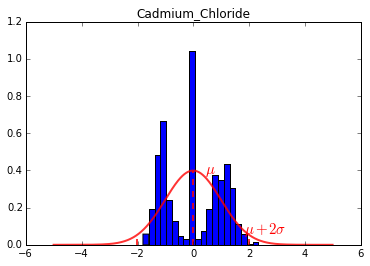

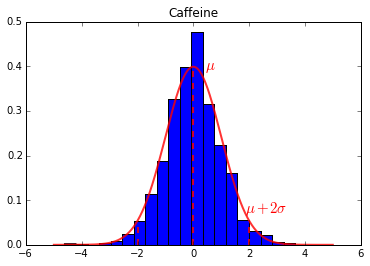

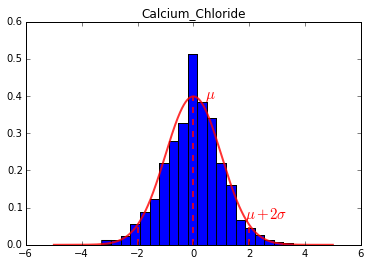

In [7]:
for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[3,3])#create the figure
    
    #histogram of the untransformed phenotypes
    plot_normal(phenotype_vals.values[:,ip],alpha=0.8)
    pl.title("%s" % p_ID)

Some of the phenotypes deviate from a normal distribution.
One of the assumptions of the linear regression model we use for association testing is that the model residuals are normal distrbuted.
Violation of this assumption leads to biases in the analysis.
We only have access to the residuals after fitting the model.
Under the assumption that the model explains only a small portion of phenotypic variation we can assess the phenotype values instead.

### Transforming phenotypes

To make the data look more normally distrbuted, we apply two different phenotype transformations, the Box-Cox transformation and a non-parametric rank-based transformation.

#### Rank-based (non-parametric) transformation

The rank-based transformation makes the data look absolutely normal by converting the data first to ranks and then transforming it to the corresponding quantiles of a normal distribution. As this transformation does not have a parameter (or actually one parameter per sample, namely the normal quantile), it is called non-paramteric.

In [8]:
phenotype_vals_ranks = preprocess.rankStandardizeNormal(phenotype_vals.values)

Let's look at the histograms after transformation:

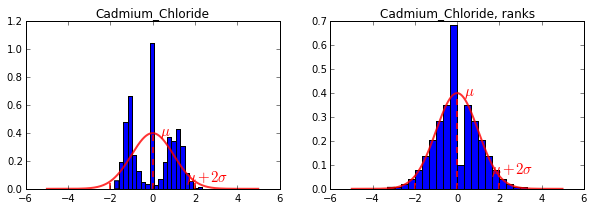

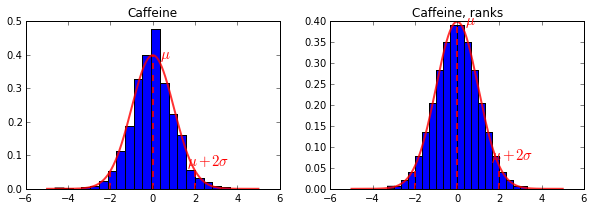

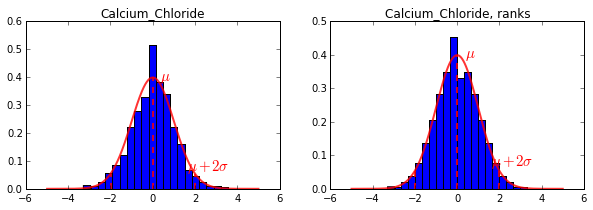

In [28]:
for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[10,3])#create the figure
    
    plt = pl.subplot(1,2,1)#the untransformed phenotypes
    #histogram of the untransformed phenotypes
    plot_normal(phenotype_vals.values[:,ip],alpha=0.8,figure=plt)
    pl.title("%s" % p_ID)
    
    plt = pl.subplot(1,2,2)#the rank transformed phenotypes
    #histogram of the untransformed phenotypes
    plot_normal(phenotype_vals_ranks[:,ip],alpha=0.8,figure=plt)
    pl.title("%s, ranks" % p_ID)

### GWAS testing using linear regression on the gaussianized phenotype:

In [41]:
#run linear regression on each SNP
lm = qtl.test_lm(snps=snps[sample_idx],pheno=phenotype_vals_ranks)

#get p-values back
pv = lm.getPv()
pv.shape

(3, 11623)

A common way to visualize the results of a GWAS is a Manhatten plot, where the $-log_{10}$ P-values are plotted against the genomic position.

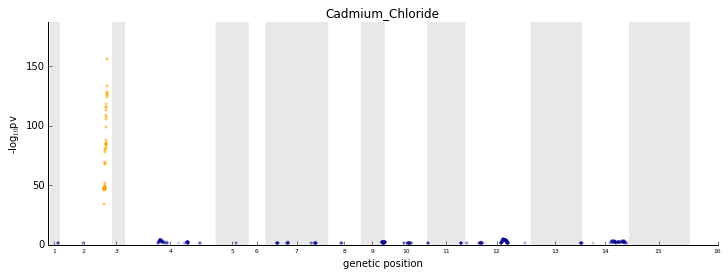

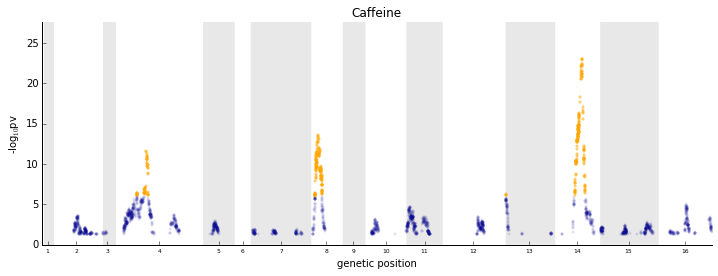

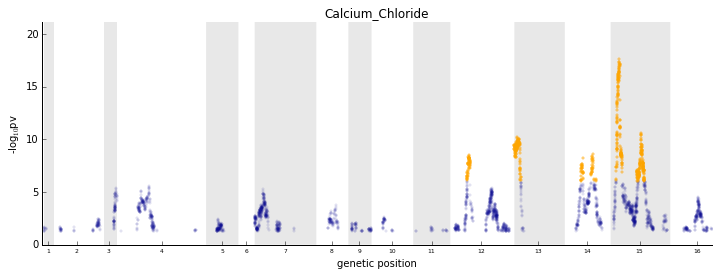

In [30]:
# get positions for manhattan plot
position = dataset.getPos()
position,chromBounds = data_util.estCumPos(position=position,offset=0)

# Genome-wide manhatton plots for one phenotype:
for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[12,4])
    plot_manhattan(posCum=position['pos_cum'],pv=pv[ip,:],chromBounds=chromBounds,thr_plotting=0.05)
    pl.title(p_ID)

### Observations:

* Several peaks are visible.

* The peaks entail multiple neighboring SNPs due to linkage disequilibrium to the causal variant.

Next, we look at the residuals at the strongest associated SNP by plotting the phenotype values against the SNP genotypes.

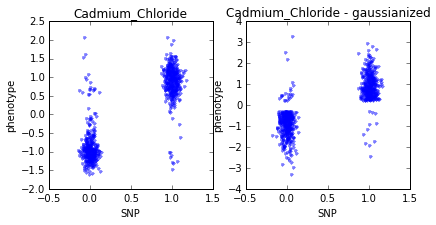

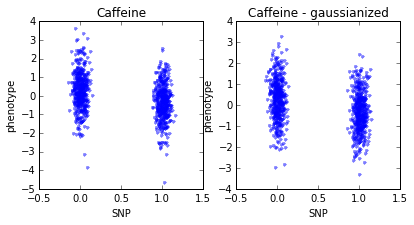

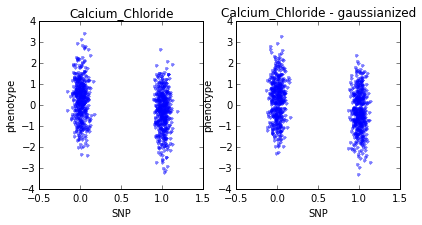

In [32]:

for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[10,3])#create the figure
    
    plt = pl.subplot(1,3,1)#the untransformed phenotypes
    #find maximum squared beta value
    pheno_vals, s_idx = dataset.getPhenotypes([p_ID])
    
    imax = lm.pvalues[ip].argmin()
    i_0 = snps[s_idx,imax]==0

    #plot SNP vs. phenotype for max beta
    
    pl.plot(snps[s_idx,imax]+0.05*np.random.randn(snps[s_idx,imax].shape[0]),pheno_vals.values,'.',alpha=0.5)
    
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s" % p_ID)
    
    plt = pl.subplot(1,3,2)#the rank transformed phenotypes
    pl.plot(snps[s_idx,imax]+0.05*np.random.randn(snps[s_idx,imax].shape[0]),phenotype_vals_ranks[s_idx[sample_idx],ip],'.',alpha=0.5)
    
    #pl.plot([0,1],[pheno_vals.values[i_0].mean(),pheno_vals.values[~i_0].mean()])
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s - gaussianized" % p_ID)
    

There is an interesting artifact visible from the rank-transformation. On the original data there are two peaks visible. By making the data look normal distributed, the two peaks are merged together. Once conditioning on the strongest SNP, which seems to have a Mendelian effect on the phenotype, the residuals become less normal distributed than for the original data.

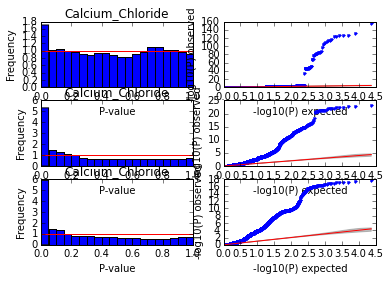

In [33]:
# PHENOTYPE 1
# P-value histgrams
pl.subplot(3,2,1)
pl.hist(pv[0],20,normed=True)
pl.plot([0,1],[1,1],"r")
pl.title("%s" % p_ID)
pl.xlabel("P-value")
pl.ylabel("Frequency")
# QQplot
pl.subplot(3,2,2)
qqplot(pv[0])

# PHENOTYPE 2
# P-value histgrams
pl.subplot(3,2,3)
pl.hist(pv[1],20,normed=True)
pl.plot([0,1],[1,1],"r")
pl.title("%s" % p_ID)
pl.xlabel("P-value")
pl.ylabel("Frequency")
# QQplot
pl.subplot(3,2,4)
qqplot(pv[1])

# PHENOTYPE 3
# P-value histgrams
pl.subplot(3,2,5)
pl.hist(pv[2],20,normed=True)
pl.plot([0,1],[1,1],"r")
pl.title("%s" % p_ID)
pl.xlabel("P-value")
pl.ylabel("Frequency")
# QQplot
pl.subplot(3,2,6)
qqplot(pv[2])
    

### P-values on permuted data

By permuting the data we break any dependence between the SNP and the phenotype, making the data come from the null distribution (no association).

In [39]:
#1. generate permutation
sp.random.seed(0)
idxs = sp.random.permutation(phenotype_vals_ranks.shape[0])
permutes_phenotypes = phenotype_vals_ranks[idxs, :]

#2. run linear regression on each SNP for permuted phenotypes
lm_perm = qtl.test_lm(snps=snps[sample_idx],pheno=permutes_phenotypes)

#3. get p-values back
pv_perm = lm_perm.getPv()

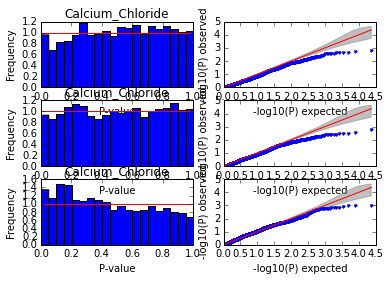

In [40]:
# PHENOTYPE 1
# P-value histgrams
pl.subplot(3,2,1)
pl.hist(pv_perm[0],20,normed=True)
pl.plot([0,1],[1,1],"r")
pl.title("%s" % p_ID)
pl.xlabel("P-value")
pl.ylabel("Frequency")
# QQplot
pl.subplot(3,2,2)
qqplot(pv[0])

# PHENOTYPE 2
# P-value histgrams
pl.subplot(3,2,3)
pl.hist(pv_perm[1],20,normed=True)
pl.plot([0,1],[1,1],"r")
pl.title("%s" % p_ID)
pl.xlabel("P-value")
pl.ylabel("Frequency")
# QQplot
pl.subplot(3,2,4)
qqplot(pv[1])

# PHENOTYPE 3
# P-value histgrams
pl.subplot(3,2,5)
pl.hist(pv_perm[2],20,normed=True)
pl.plot([0,1],[1,1],"r")
pl.title("%s" % p_ID)
pl.xlabel("P-value")
pl.ylabel("Frequency")
# QQplot
pl.subplot(3,2,6)
qqplot(pv[2])

## False discovery rates

False discovery rates (FDR) give an idea on the expected type-1 error rate at a given P-value threshold. If we are testing millions of hypotheses, then we might be willing to accept type-1 errors at a given rate, if in return we get more discoveries.

This measure gives a useful alternative to traditional Bonferroni correction, which bounds the so-called family-wise error rate (FWER), namely the probability of having at least a single type 1 error.



#### $q$-values

Definition: minimum false discovery rate threshold that would allow the variable to be significant.

To compare the differences and similarities between multiple hypothesis correction via the false discovery rate and the family-wise error rate, we plot q-values (estimated by the Benjamini and Hochberg procedure) and the family-wise error rate (upper bounded by the Bonferoni method)

(0, 10)

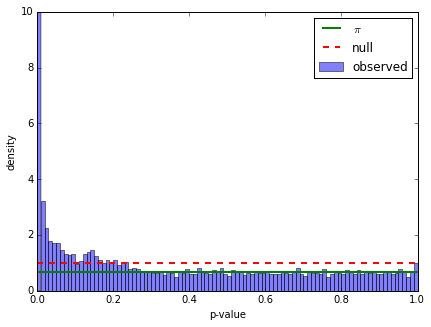

In [42]:
#fitting q-values using the Benjamini-Hochberg step-down procedure

import limix.stats.fdr as fdr
fig = pl.figure(3,figsize=[15,5])

#1. on the real tests
pl.subplot(1,2,1)
qv, pi0 = fdr.qvalues(lm.pvalues[1], return_pi0=True)
#plot distribution of p-values and fitted \pi parameter:
fig = pl.figure(3,figsize=[8,5])
pl.hist(lm.pvalues[1],bins=100,normed=True,color='b',label='observed',alpha=0.5)
pl.axhline(pi0,color='g',linewidth=2,label='$\pi$')
pl.axhline(1,color='r',linestyle='--',linewidth=2,label='null')
pl.legend()
pl.xlabel('p-value')
pl.ylabel('density')
pl.ylim((0,10))



(0, 10)

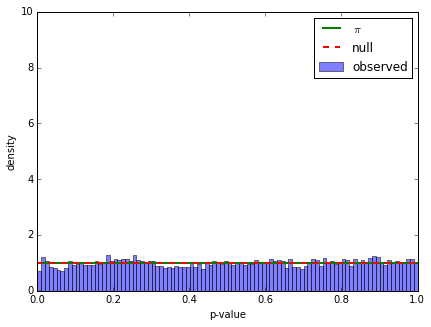

In [44]:
fig = pl.figure(3,figsize=[15,5])

#2. on permuted p-values
pl.subplot(1,2,2)
qv_perm, pi0 = fdr.qvalues(lm_perm.pvalues[1], return_pi0=True)
#plot distribution of p-values and fitted \pi parameter:
pl.hist(lm_perm.pvalues[1],bins=100,normed=True,color='b',label='observed',alpha=0.5)
pl.axhline(pi0,color='g',linewidth=2,label='$\pi$')
pl.axhline(1,color='r',linestyle='--',linewidth=2,label='null')
pl.legend()
pl.xlabel('p-value')
pl.ylabel('density')
pl.ylim((0,10))

To compare the differences and similarities between multiple hypothesis correctin via the false discovery rate and the family-wise error rate, we plot q-values (estimated by the Benjamini and Hochberg procedure) and the family-wise error rate (upper bounded by the Bonferoni method)

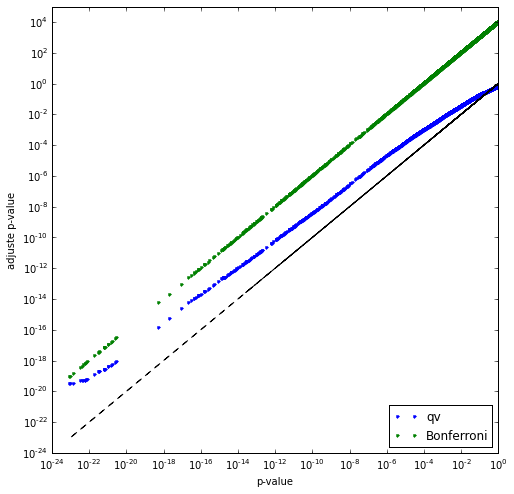

In [47]:
# compare q-values against p-values and Bonferroni adjustement:
pl.figure(figsize=[8,8])
pl.plot((lm.pvalues[1]),(qv),'.',label = 'qv')
pl.plot((lm.pvalues[1]),(lm.pvalues[1]*snps.shape[1]),'.',label = 'Bonferroni')
pl.plot(lm.pvalues[1],lm.pvalues[1],'k--')
pl.yscale("log")
pl.xscale("log")
pl.xlabel('p-value')
pl.ylabel('adjuste p-value')
pl.legend(loc='lower right')